✓ curve_db is already loaded with 437226 isogeny classes

Generating phis using shifted fraction sampling (phi = m/n + 5)...
Using 28 CPU cores


Phi generation: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 817.45it/s]


Initial phi set: 39800 (redundant) rational values
After removing duplicates: 12175 unique rational values

Processing phis...


Loading conductors: 100%|████████████████████████████████████████████████████████| 12175/12175 [01:51<00:00, 109.46it/s]


Found 380 phis in database below 100,000 conductors, associated to distinct isogeny classes

Saving results...
Saved scan data to HV_curves_shifted/(-100,100)_shift5_phi_scan_data.sobj
Saved individual lists:
  - HV_curves_shifted/(-100,100)_shift5_phi_reps.sobj
  - HV_curves_shifted/(-100,100)_shift5_conductors.sobj
  - HV_curves_shifted/(-100,100)_shift5_isogeny_classes.sobj

SUMMARY
Range: m, n ∈ [-100, 100)
Shift: phi = m/n + 5
Total phis generated: 12175
Unique isogeny classes found: 380
Success rate: 3.12%
Conductor range: [14, 99484]

Creating enhanced visualizations...
Saved plot: HV_curves_shifted/(-100,100)_shift5_phi_distribution.png


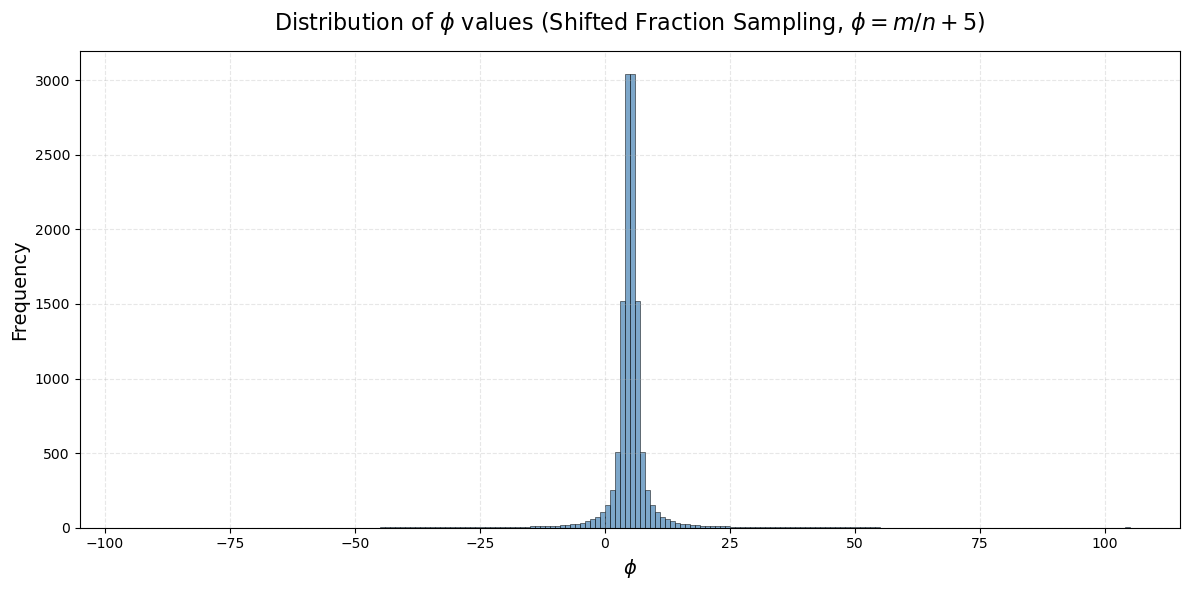

Saved plot: HV_curves_shifted/(-100,100)_shift5_conductor_vs_phi.png


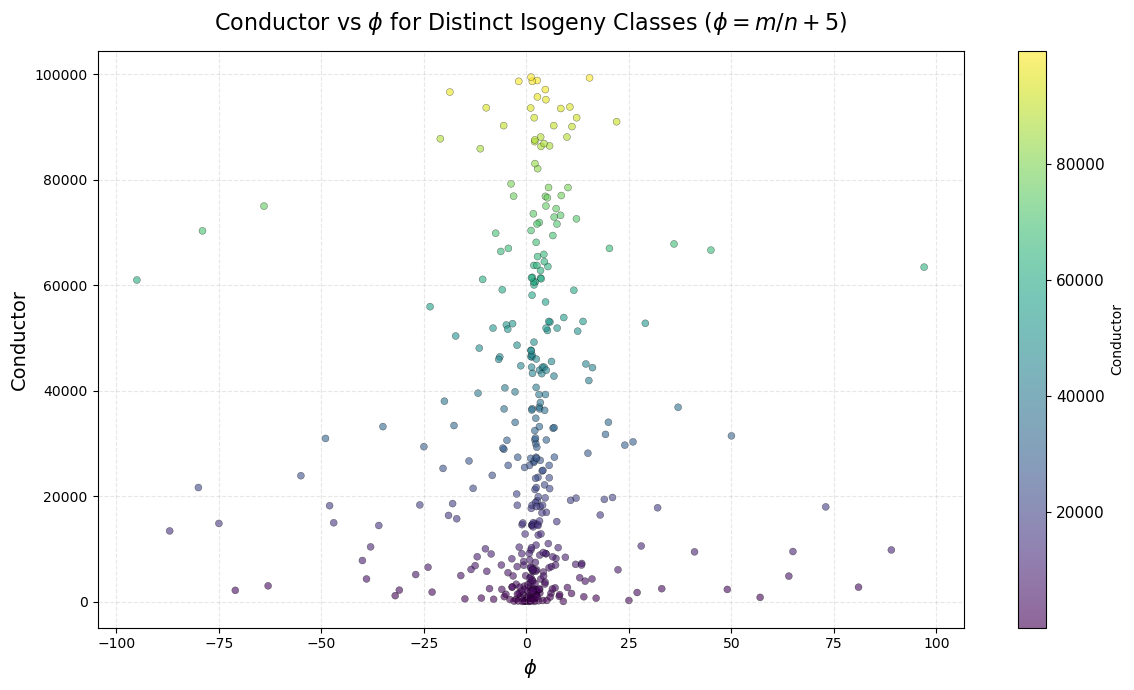

Saved plot: HV_curves_shifted/(-100,100)_shift5_conductor_distribution_enhanced.png


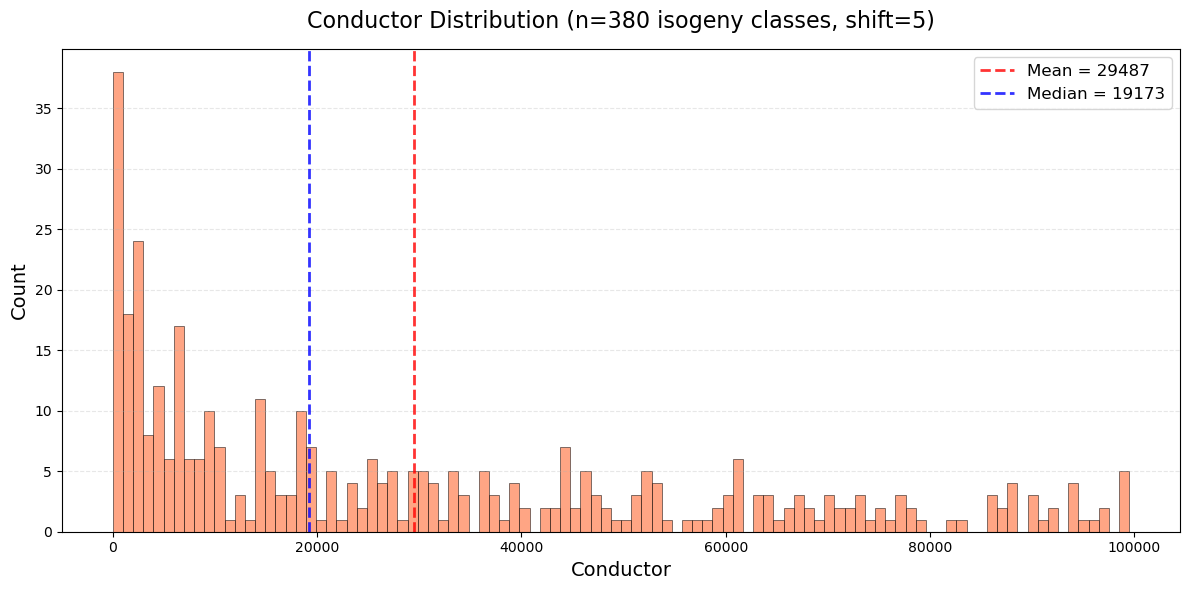


Extracting ap coefficients by rank...


Loading aps: 100%|████████████████████████████████████████████████████████████████| 380/380 [00:00<00:00, 254281.35it/s]

Averaging the aps...
Done.

Rank 0: 189 isogeny classes
Rank 1: 184 isogeny classes
Rank 2: 7 isogeny classes
Rank 3: 0 isogeny classes

Saved average aps to HV_curves_shifted/(-100,100)_shift5_average_aps.sobj

Creating ap coefficient plots...


Saved plot: HV_curves_shifted/(-100,100)_shift5_ap_averages_rank0_vs_rank1.png


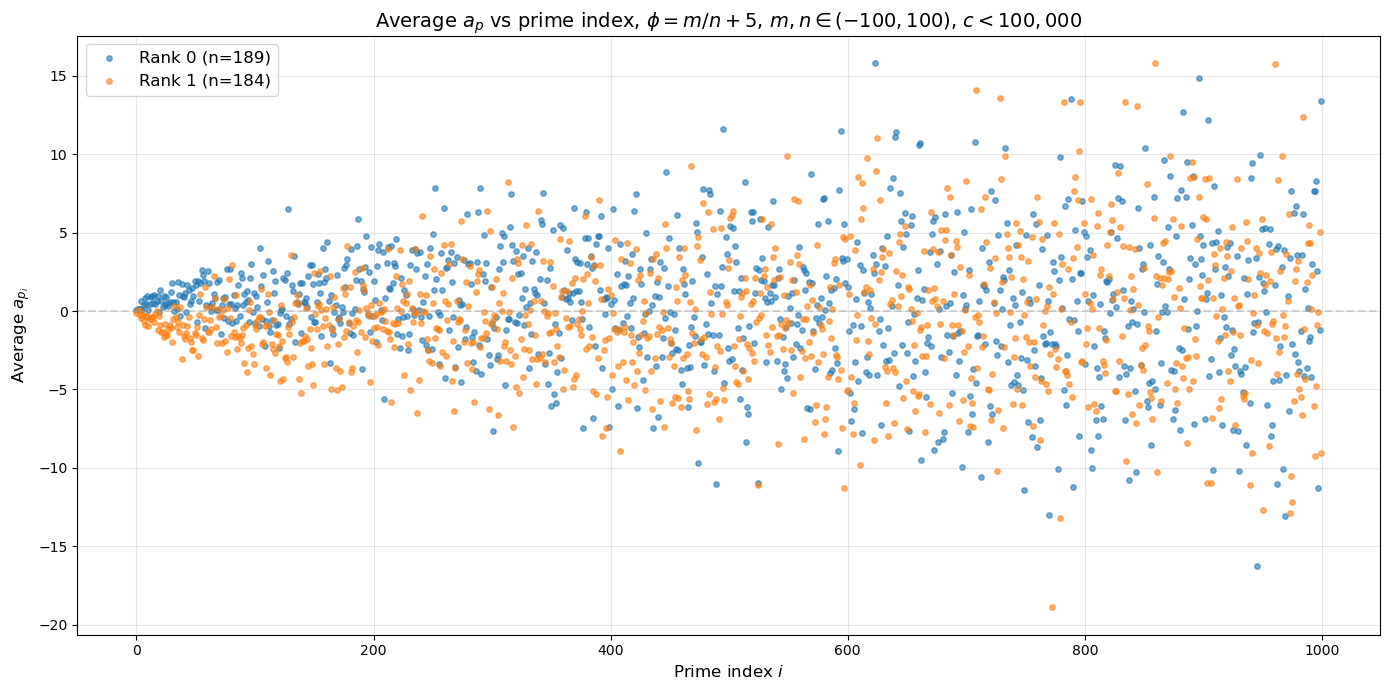

Skipped all ranks plot: would be identical to rank 0 vs rank 1 plot

Done!
All isogeny classes from fraction sampling around 5 are contained in the ones obtained from fraction sampling around zero.


In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, cpu_count
import os

# Check if curve_db is loaded, if not load it
try:
    curve_db
    print(f"✓ curve_db is already loaded with {len(curve_db)} isogeny classes")
except NameError:
    print("Loading curve database...")
    curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')
    print(f"✓ Loaded curve_db with {len(curve_db)} isogeny classes")
print()

def elliptic_curve_from_phi(phi):
    """
    Compute the Weierstrass coefficients (a, b) for the elliptic curve:
    y² = x³ + ax + b
    
    where the coefficients are given in terms of φ by equation (70):
    a = -(9φ⁴ - 12φ³ + 30φ² - 12φ + 1) / 3
    b = -2(27φ⁶ - 54φ⁵ - 135φ⁴ + 180φ³ - 99φ² + 18φ - 1) / 27
    
    Parameters:
    -----------
    phi : numeric (int, float, or symbolic)
        The parameter φ
    
    Returns:
    --------
    tuple : (a, b)
        The two Weierstrass coefficients
    """
    # Compute coefficient a
    a_numerator = 9*phi**4 - 12*phi**3 + 30*phi**2 - 12*phi + 1
    a = -a_numerator / 3
    
    # Compute coefficient b
    b_numerator = 27*phi**6 - 54*phi**5 - 135*phi**4 + 180*phi**3 - 99*phi**2 + 18*phi - 1
    b = -2 * b_numerator / 27
    
    return a, b

def elliptic_curve_from_phi_sage(phi):
    """
    SageMath version that returns an actual EllipticCurve object.
    
    Parameters:
    -----------
    phi : numeric or symbolic
        The parameter φ
    
    Returns:
    --------
    EllipticCurve : Sage EllipticCurve object
    """
    from sage.all import EllipticCurve, QQ
    
    a, b = elliptic_curve_from_phi(phi)
    
    # Create elliptic curve in Weierstrass form [0, 0, 0, a, b]
    return EllipticCurve([0, 0, 0, a, b])

def generate_phis_for_m(args):
    """
    Generate all phi values for a given m value using shifted fraction sampling.
    
    Shifted fraction sampling: phi = m/n + nshift where m, n are integers in specified range
    """
    m, nmin, nmax, nshift = args
    local_phis = []
    for n in range(nmin, nmax):
        if n != 0:
            local_phis.append(QQ(m/n + nshift))
    return local_phis

def get_isogeny_class(label):
    """Extract isogeny class from label (e.g., '37a2' -> '37a')"""
    i = len(label) - 1
    while i >= 0 and label[i].isdigit():
        i -= 1
    return label[:i+1]

def process_phi(phi):
    """Worker function to process a single phi value"""
    try:
        # Get the elliptic curve and its Cremona label
        E = elliptic_curve_from_phi_sage(phi)
        label = E.label()
        
        # Extract isogeny class from label (string manipulation)
        iso = get_isogeny_class(label)
        
        # Look up in database by isogeny class
        curve = curve_db[iso]
        c = curve['conductor']
        
        return (phi, c, iso)
    except:
        return None

# ============================================================================
# SHIFTED FRACTION SAMPLING: Generate phi = m/n + nshift for m, n in range [nmin, nmax]
# ============================================================================

nmax = 100
nmin = -100
nshift = 5

# Create output directory
output_dir = 'HV_curves_shifted'
os.makedirs(output_dir, exist_ok=True)

# Parallelize phi generation using shifted fraction sampling
print(f"Generating phis using shifted fraction sampling (phi = m/n + {nshift})...")
print(f"Using {cpu_count()} CPU cores")
m_values = [(m, nmin, nmax, nshift) for m in range(nmin, nmax)]

with Pool(processes=cpu_count()) as pool:
    phi_lists = list(tqdm(
        pool.imap(generate_phis_for_m, m_values),
        total=len(m_values),
        desc="Phi generation"
    ))

# Flatten the list of lists
phis = [phi for sublist in phi_lists for phi in sublist]

print(f"Initial phi set: {len(phis)} (redundant) rational values")

# Remove duplicates
phis = list(set(phis))
print(f"After removing duplicates: {len(phis)} unique rational values")

# ============================================================================
# PROCESS PHIS: Match to elliptic curves in database
# ============================================================================

print(f"\nProcessing phis...")
with Pool(processes=cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(process_phi, phis),
        total=len(phis),
        desc="Loading conductors"
    ))

# Filter out None results and keep only unique isogeny classes
cs = []
seen_iso_classes = []
phi_reps = []
for result in results:
    if result is not None:
        phi, c, iso = result
        if iso not in seen_iso_classes:
            cs.append(c)
            seen_iso_classes.append(iso)
            phi_reps.append(phi)

print(f"Found {len(phi_reps)} phis in database below 100,000 conductors, associated to distinct isogeny classes")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\nSaving results...")
scan_data = {
    'phi_reps': phi_reps,
    'conductors': cs,
    'isogeny_classes': seen_iso_classes,
    'total_phis_generated': len(phis),
    'total_found': len(phi_reps),
    'nmin': nmin,
    'nmax': nmax,
    'nshift': nshift
}

save(scan_data, f'{output_dir}/({nmin},{nmax})_shift{nshift}_phi_scan_data.sobj')
print(f"Saved scan data to {output_dir}/({nmin},{nmax})_shift{nshift}_phi_scan_data.sobj")

# Save individual lists
save(phi_reps, f'{output_dir}/({nmin},{nmax})_shift{nshift}_phi_reps.sobj')
save(cs, f'{output_dir}/({nmin},{nmax})_shift{nshift}_conductors.sobj')
save(seen_iso_classes, f'{output_dir}/({nmin},{nmax})_shift{nshift}_isogeny_classes.sobj')

print("Saved individual lists:")
print(f"  - {output_dir}/({nmin},{nmax})_shift{nshift}_phi_reps.sobj")
print(f"  - {output_dir}/({nmin},{nmax})_shift{nshift}_conductors.sobj")
print(f"  - {output_dir}/({nmin},{nmax})_shift{nshift}_isogeny_classes.sobj")

# Print summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Range: m, n ∈ [{nmin}, {nmax})")
print(f"Shift: phi = m/n + {nshift}")
print(f"Total phis generated: {len(phis)}")
print(f"Unique isogeny classes found: {len(phi_reps)}")
print(f"Success rate: {int(100)*len(phi_reps)/len(phis):.2f}%")
print(f"Conductor range: [{min(cs)}, {max(cs)}]")
print("="*60)

# ============================================================================
# ENHANCED PLOTTING SECTION
# ============================================================================

print("\nCreating enhanced visualizations...")

# Plot 1: Phi distribution (enhanced)
phis_float = [float(phi) for phi in phis]

plt.figure(figsize=(12, 6))
plt.hist(phis_float, bins=200, color='steelblue', edgecolor='black', alpha=0.7, linewidth=0.5)
plt.xlabel(r'$\phi$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(rf'Distribution of $\phi$ values (Shifted Fraction Sampling, $\phi = m/n + {nshift}$)', fontsize=16, pad=15)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(f'{output_dir}/({nmin},{nmax})_shift{nshift}_phi_distribution.png', dpi=150, bbox_inches='tight')
print(f"Saved plot: {output_dir}/({nmin},{nmax})_shift{nshift}_phi_distribution.png")
plt.show()
plt.close()

# Plot 2: Conductor vs phi (enhanced with colormap)
plt.figure(figsize=(12, 7))
scatter = plt.scatter(phi_reps, cs, c=cs, cmap='viridis', 
                     alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
cbar = plt.colorbar(scatter, label='Conductor')
cbar.ax.tick_params(labelsize=11)
plt.xlabel(r'$\phi$', fontsize=14)
plt.ylabel('Conductor', fontsize=14)
plt.title(rf'Conductor vs $\phi$ for Distinct Isogeny Classes ($\phi = m/n + {nshift}$)', fontsize=16, pad=15)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(f'{output_dir}/({nmin},{nmax})_shift{nshift}_conductor_vs_phi.png', dpi=150, bbox_inches='tight')
print(f"Saved plot: {output_dir}/({nmin},{nmax})_shift{nshift}_conductor_vs_phi.png")
plt.show()
plt.close()

# Plot 3: Conductor distribution (enhanced with statistics)
plt.figure(figsize=(12, 6))
plt.hist(cs, bins=100, color='coral', edgecolor='black', alpha=0.7, linewidth=0.5)
plt.xlabel('Conductor', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title(f'Conductor Distribution (n={len(cs)} isogeny classes, shift={nshift})', fontsize=16, pad=15)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
# Add statistics annotation
mean_c = np.mean(cs)
median_c = np.median(cs)
plt.axvline(mean_c, color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {mean_c:.0f}', alpha=0.8)
plt.axvline(median_c, color='blue', linestyle='--', linewidth=2, 
           label=f'Median = {median_c:.0f}', alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig(f'{output_dir}/({nmin},{nmax})_shift{nshift}_conductor_distribution_enhanced.png', dpi=150, bbox_inches='tight')
print(f"Saved plot: {output_dir}/({nmin},{nmax})_shift{nshift}_conductor_distribution_enhanced.png")
plt.show()
plt.close()

# ============================================================================
# EXTRACT AND ANALYZE AP COEFFICIENTS BY RANK
# ============================================================================

print("\nExtracting ap coefficients by rank...")

# Extract average aps sorted by rank
rk0_aps = []
rk1_aps = []
rk2_aps = []
rk3_aps = []
for iso in tqdm(seen_iso_classes, desc="Loading aps"):
    curve = curve_db[iso]
    rk = curve['rank']
    aps = curve['ap_list']
    if rk == 0:
        rk0_aps.append(aps)
    elif rk == 1:
        rk1_aps.append(aps)
    elif rk == 2:
        rk2_aps.append(aps)
    elif rk == 3:
        rk3_aps.append(aps)

# Convert to numpy arrays
rk0_aps = np.array(rk0_aps) if len(rk0_aps) > 0 else None
rk1_aps = np.array(rk1_aps) if len(rk1_aps) > 0 else None
rk2_aps = np.array(rk2_aps) if len(rk2_aps) > 0 else None
rk3_aps = np.array(rk3_aps) if len(rk3_aps) > 0 else None

print("Averaging the aps...")
rk0_average_aps = np.mean(rk0_aps, axis=0) if rk0_aps is not None else None
rk1_average_aps = np.mean(rk1_aps, axis=0) if rk1_aps is not None else None
rk2_average_aps = np.mean(rk2_aps, axis=0) if rk2_aps is not None else None
rk3_average_aps = np.mean(rk3_aps, axis=0) if rk3_aps is not None else None
print("Done.")

# Print statistics
print(f"\nRank 0: {len(rk0_aps) if rk0_aps is not None else 0} isogeny classes")
print(f"Rank 1: {len(rk1_aps) if rk1_aps is not None else 0} isogeny classes")
print(f"Rank 2: {len(rk2_aps) if rk2_aps is not None else 0} isogeny classes")
print(f"Rank 3: {len(rk3_aps) if rk3_aps is not None else 0} isogeny classes")

# ============================================================================
# SAVE AP COEFFICIENT DATA
# ============================================================================

# Save the data
averages_data = {
    'rank_0_average': rk0_average_aps.tolist() if rk0_average_aps is not None else None,
    'rank_1_average': rk1_average_aps.tolist() if rk1_average_aps is not None else None,
    'rank_2_average': rk2_average_aps.tolist() if rk2_average_aps is not None else None,
    'rank_3_average': rk3_average_aps.tolist() if rk3_average_aps is not None else None,
    'rank_0_count': len(rk0_aps) if rk0_aps is not None else 0,
    'rank_1_count': len(rk1_aps) if rk1_aps is not None else 0,
    'rank_2_count': len(rk2_aps) if rk2_aps is not None else 0,
    'rank_3_count': len(rk3_aps) if rk3_aps is not None else 0,
    'phi_reps': phi_reps,
    'isogeny_classes': seen_iso_classes,
    'conductors': cs,
    'nshift': nshift
}

save(averages_data, f'{output_dir}/({nmin},{nmax})_shift{nshift}_average_aps.sobj')
print(f"\nSaved average aps to {output_dir}/({nmin},{nmax})_shift{nshift}_average_aps.sobj")

# Save individual arrays
if rk0_average_aps is not None:
    save(rk0_average_aps, f'{output_dir}/({nmin},{nmax})_shift{nshift}_rk0_average_aps.sobj')
if rk1_average_aps is not None:
    save(rk1_average_aps, f'{output_dir}/({nmin},{nmax})_shift{nshift}_rk1_average_aps.sobj')
if rk2_average_aps is not None:
    save(rk2_average_aps, f'{output_dir}/({nmin},{nmax})_shift{nshift}_rk2_average_aps.sobj')
if rk3_average_aps is not None:
    save(rk3_average_aps, f'{output_dir}/({nmin},{nmax})_shift{nshift}_rk3_average_aps.sobj')

# ============================================================================
# PLOT AP COEFFICIENTS BY RANK
# ============================================================================

# Create plots
N = len(rk0_average_aps) if rk0_average_aps is not None else (
     len(rk1_average_aps) if rk1_average_aps is not None else 0)

# Define minimum sample size for plotting
MIN_SAMPLES = 100

if N > 0:
    print("\nCreating ap coefficient plots...")
    
    # Plot 1: Rank 0 vs Rank 1
    plt.figure(figsize=(14, 7))
    plot_count_rk01 = 0
    if rk0_aps is not None and len(rk0_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk0_average_aps, 
                   label=f"Rank 0 (n={len(rk0_aps)})", alpha=0.6, s=15)
        plot_count_rk01 += 1
    if rk1_aps is not None and len(rk1_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk1_average_aps, 
                   label=f"Rank 1 (n={len(rk1_aps)})", alpha=0.6, s=15)
        plot_count_rk01 += 1
    
    if plot_count_rk01 > 0:
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlabel(r"Prime index $i$", fontsize=12)
        plt.ylabel(r"Average $a_{p_i}$", fontsize=12)
        plt.title(fr"Average $a_p$ vs prime index, $\phi=m/n+{nshift}$, $m,n\in({nmin},{nmax})$, $c<100,000$", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/({nmin},{nmax})_shift{nshift}_ap_averages_rank0_vs_rank1.png', dpi=150)
        print(f"Saved plot: {output_dir}/({nmin},{nmax})_shift{nshift}_ap_averages_rank0_vs_rank1.png")
        plt.show()
    else:
        print(f"Skipped rank 0 vs rank 1 plot: insufficient data (need at least {MIN_SAMPLES} curves per rank)")
    plt.close()
    
    # Check if we have additional ranks beyond 0 and 1
    has_additional_ranks = False
    if rk2_aps is not None and len(rk2_aps) >= MIN_SAMPLES:
        has_additional_ranks = True
    if rk3_aps is not None and len(rk3_aps) >= MIN_SAMPLES:
        has_additional_ranks = True
    
    # Plot 2: All ranks (only if different from rank 0 vs rank 1)
    if has_additional_ranks:
        plt.figure(figsize=(14, 7))
        plot_count_all = 0
        if rk0_aps is not None and len(rk0_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk0_average_aps, 
                       label=f"Rank 0 (n={len(rk0_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        if rk1_aps is not None and len(rk1_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk1_average_aps, 
                       label=f"Rank 1 (n={len(rk1_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        if rk2_aps is not None and len(rk2_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk2_average_aps, 
                       label=f"Rank 2 (n={len(rk2_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        if rk3_aps is not None and len(rk3_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk3_average_aps, 
                       label=f"Rank 3 (n={len(rk3_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        
        if plot_count_all > 0:
            plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
            plt.legend(fontsize=12)
            plt.xlabel(r"Prime index $i$", fontsize=12)
            plt.ylabel(r"Average $a_{p_i}$", fontsize=12)
            plt.title(fr"Average $a_p$ by rank, $\phi=m/n+{nshift}$, $m,n\in({nmin},{nmax})$, $c<100,000$", fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/({nmin},{nmax})_shift{nshift}_ap_averages_all_ranks.png', dpi=150)
            print(f"Saved plot: {output_dir}/({nmin},{nmax})_shift{nshift}_ap_averages_all_ranks.png")
            plt.show()
        plt.close()
    else:
        print(f"Skipped all ranks plot: would be identical to rank 0 vs rank 1 plot")
    
    if plot_count_rk01 > 0 or has_additional_ranks:
        print("\nDone!")
    else:
        print("\nNo ranks with sufficient statistics to plot")
else:
    print("\nNo data to plot")

# Check if I found some new classes wrt fraction sampling around zero

shifted_data = load(f"HV_curves_shifted/({nmin},{nmax})_shift{nshift}_average_aps")
fraction_data = load("HV_curves/(-2000,2000)_average_aps.sobj")
shifted_iso = shifted_data['isogeny_classes']
fraction_iso = fraction_data['isogeny_classes']

tot_iso = list(set(fraction_iso + shifted_iso))

if len(tot_iso) == len(fraction_iso):
    print(f"All isogeny classes from fraction sampling around {nshift} are contained in the ones obtained from fraction sampling around zero.")
else:
    print(f"{len(tot_iso) - len(fraction_iso)} isogeny classes from fraction sampling around {nshift} are NOT contained in the ones obtained from fraction sampling around zero.")